# Rumour Analysis with COVID-19 Data

In [1]:
! pip install spacy seaborn
! python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 9.6 MB/s eta 0:00:01    |███████████████████▏            | 8.2 MB 8.9 MB/s eta 0:00:01| 9.6 MB 8.9 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import string
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

# Loading customization for plots
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading sklearn packages for modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from nltk.corpus import stopwords
stopword = stopwords.words('english')

## Load data

In [5]:
import dataloader

In [6]:
covid_df = dataloader.load_data(data_file = '../data/covid.data.jsonl', label_file = '../data/covid.predicted_label.json', perform_stemming = False)

In [7]:
covid_df['source_tweet'][0]

'according to the new york times  warner bros  wanted to delay christopher nolan s tenet months ago due to the covid    pandemic but nolan refused to listen to any discussions  the studio kept the original release date to  keep [nolan] happy'

In [8]:
sum(covid_df['label'] == 1)

1088

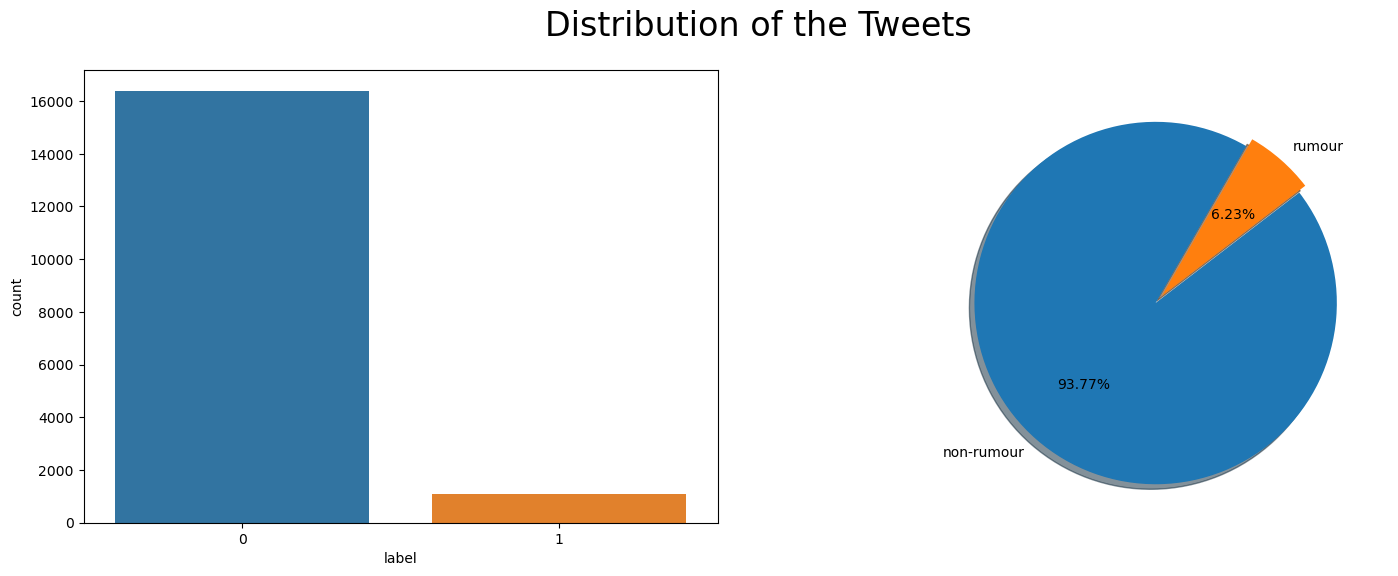

In [9]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(covid_df['label'], ax=axes[0])
axes[1].pie(covid_df['label'].value_counts(),
            labels=['non-rumour', 'rumour'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

## Analysis 1: What are the topics of COVID-19 rumours? How do they differ from the non-rumours? How do these topics evolve over time?

### Character count for tweet chains

In [10]:
covid_df['Character Count'] = covid_df['text'].apply(lambda x: len(str(x)))

In [11]:
def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

/Users/bachfischer/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/bachfischer/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


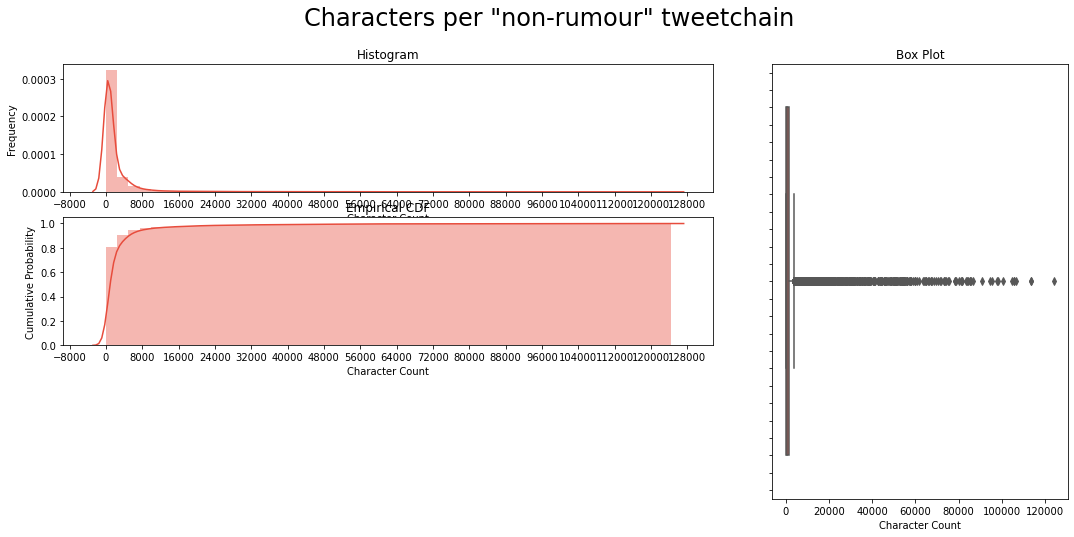

In [12]:
plot_dist3(covid_df, 'Character Count', 'Characters per "non-rumour" tweetchain')

### Word counts

In [13]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non-rumour Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Rumour Tweets')
    
    fig.suptitle('Words per tweet chain', fontsize=24, va='baseline')
    
    fig.tight_layout()

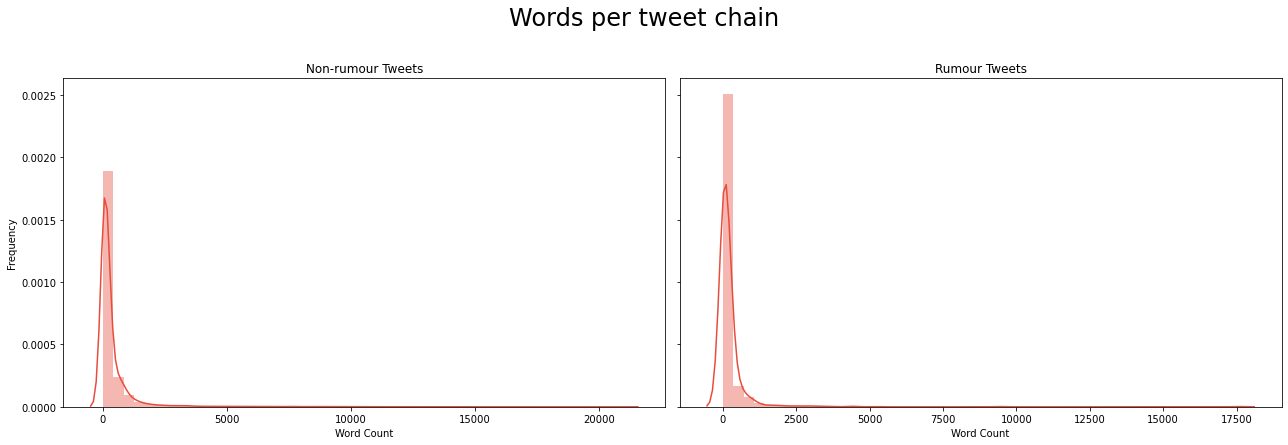

In [14]:
plot_word_number_histogram(covid_df[covid_df['label'] == 0]['text'],
                           covid_df[covid_df['label'] == 1]['text'])


### Most common words in tweet-chains

First I need to lemmatize the texts

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
def lemmatize(text):
    token = []
    result =''
    text = nlp(text)
    for t in text:
        if not t.is_stop and len(t)>2:  
            token.append(t.lemma_)
    result = ' '.join([i for i in token])
    return result

In [17]:
covid_df['lemmatized'] = covid_df['text'].apply(lambda x: lemmatize(x))

In [18]:
covid_df.head()      

,id,text,retweet_count,favorite_count,question_mark,contains_url,number_urls,contains_media,statuses_count,listed_count,...,verified,geo_enabled,has_description,length_description,source_tweet,replies,hashtags,label,Character Count,lemmatized
0,1272262651100434433,according to the new york times warner bros ...,28,280,False,False,0,True,2512,112,...,False,False,True,128,according to the new york times warner bros ...,[],[tenet],0,240,accord new york time warner bro want delay chr...
1,1287153210990395392,hurricane hanna has made landfall in texas t...,545,658,False,True,1,False,94186,5053,...,True,True,True,131,hurricane hanna has made landfall in texas t...,[guess what the cause of death is from a hurri...,[],0,249,hurricane hanna landfall texas storm hit secti...
2,1266555444283179008,monkeys on the loose in india with stolen coro...,83,179,False,True,1,True,782525,26725,...,True,False,True,159,monkeys on the loose in india with stolen coro...,[],[],0,67,monkey loose india steal coronavirus blood sample
3,1257715199655755779,eastleigh and swahili arabs in mombasa where c...,304,2306,False,False,0,False,26895,48,...,False,True,True,149,eastleigh and swahili arabs in mombasa where c...,[let is not play blind that the work is fighti...,[],0,574,eastleigh swahili arab mombasa coronavirus sky...
4,1274338812173393920,if trump felt comfortable having it here then...,856,2113,False,True,1,False,17452,1834,...,True,True,True,142,if trump felt comfortable having it here then...,"[coronavirus is very happy, another said of t...","[coronavirus, trumpscoronavirusrally, barr, ab...",0,4232,trump feel comfortable have comfortable say su...


In [19]:
lis = [
    covid_df[covid_df['label'] == 0]['lemmatized'],
    covid_df[covid_df['label'] == 1]['lemmatized']
]

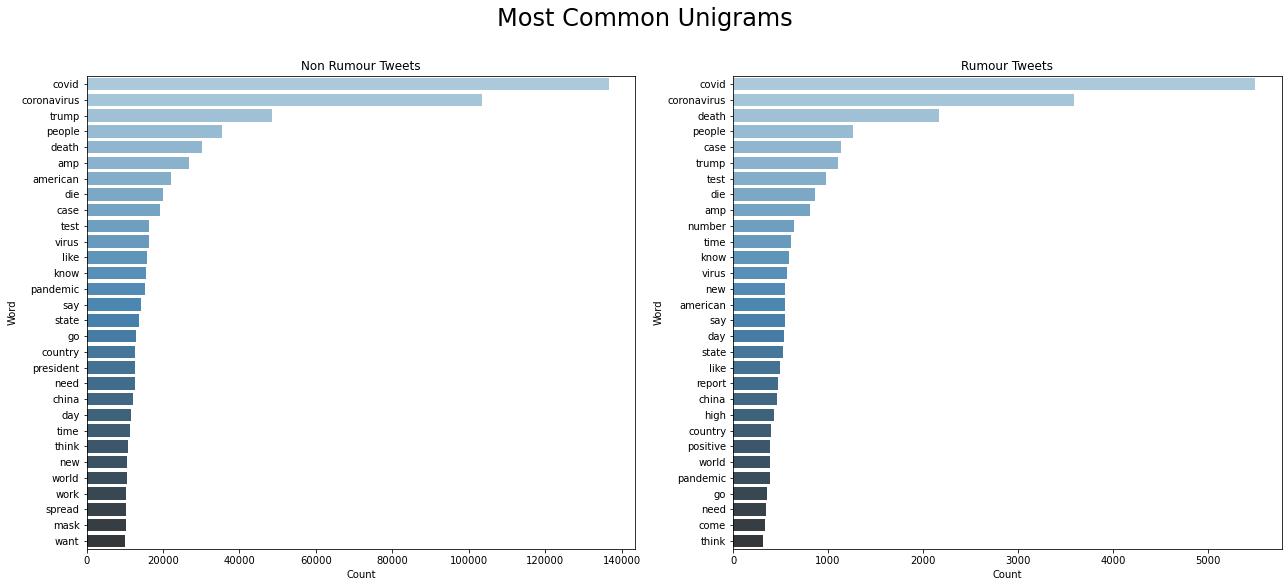

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='Blues_d', ax=j)
    
axes[0].set_title('Non Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [21]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='Blues_d', ax=j)
        
        axes[0].set_title('Non Rumour Tweets')
        axes[1].set_title('Rumour Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

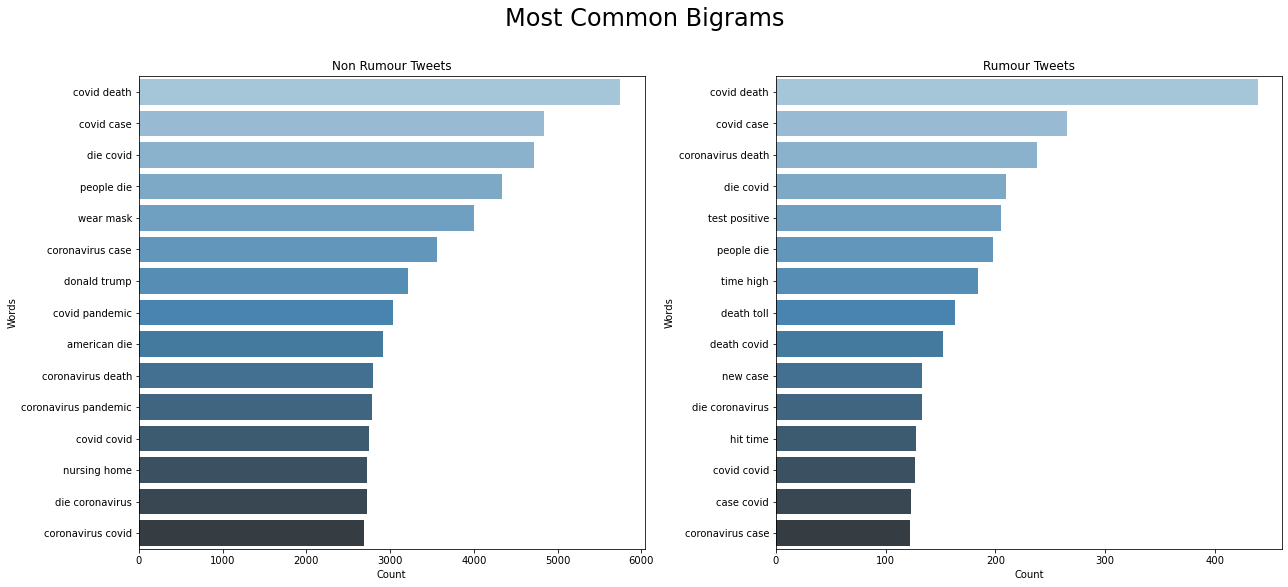

In [22]:
ngrams(2, 'Most Common Bigrams')

### Topic Exploration

Using on-Negative Matrix Factorization (NMF) on TF-IDF matrix 

In [23]:
def display_topics(text, no_top_words, topic):
    
    """ A function for determining the topics present in our corpus with nmf """
    
    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0,
              alpha=.1, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


display_topics(lis[0], 10, 'Non-Rumour Topics\n')

Non-Rumour Topics

Topic 1:
covid people amp like go good help think time thank
Topic 2:
trump american president coronavirus amp america lie response hoax donald
Topic 3:
coronavirus people like spread think pandemic say know go die
Topic 4:
death die number covid cause rate flu people count toll
Topic 5:
china wuhan chinese world virus wuhanvirus ccp country lab pandemic
Topic 6:
test positive testing negative result kit symptom covid antibody day
Topic 7:
case new florida state report number day texas record increase
Topic 8:
mask wear face people spread social distancing protect amp public
Topic 9:
home nursing patient cuomo send care hospital governor state stay
Topic 10:
vaccine hydroxychloroquine drug patient study treatment fauci doctor cure treat


In [24]:
display_topics(lis[1], 10,'Rumour Topics\n')

Rumour Topics

Topic 1:
covid people virus nigeria state amp time health follow let
Topic 2:
case new total recovery confirm report number bring today day
Topic 3:
death number toll report cause figure coronavirus count covid week
Topic 4:
coronavirus spread china man corona lockdown think rule need good
Topic 5:
test positive player day result member week testing covid negative
Topic 6:
year old contract home receive kill family worker nursing recover
Topic 7:
hospital patient doctor treat staff bed nurse recover care treatment
Topic 8:
die people say covid day doctor age confirm friend rate
Topic 9:
break navy outbreak announce ship amp official letter help send
Topic 10:
trump american china amp president pandemic mask say people know


### Named-Entity Recognition

Named-Entity recognition is a method for extracting information from text and returns which entities that are present in the text are classified into predefined entity types like "Person", "Place", "Organization", etc. By using NER we can get great insights about the types of entities present in the given text dataset.

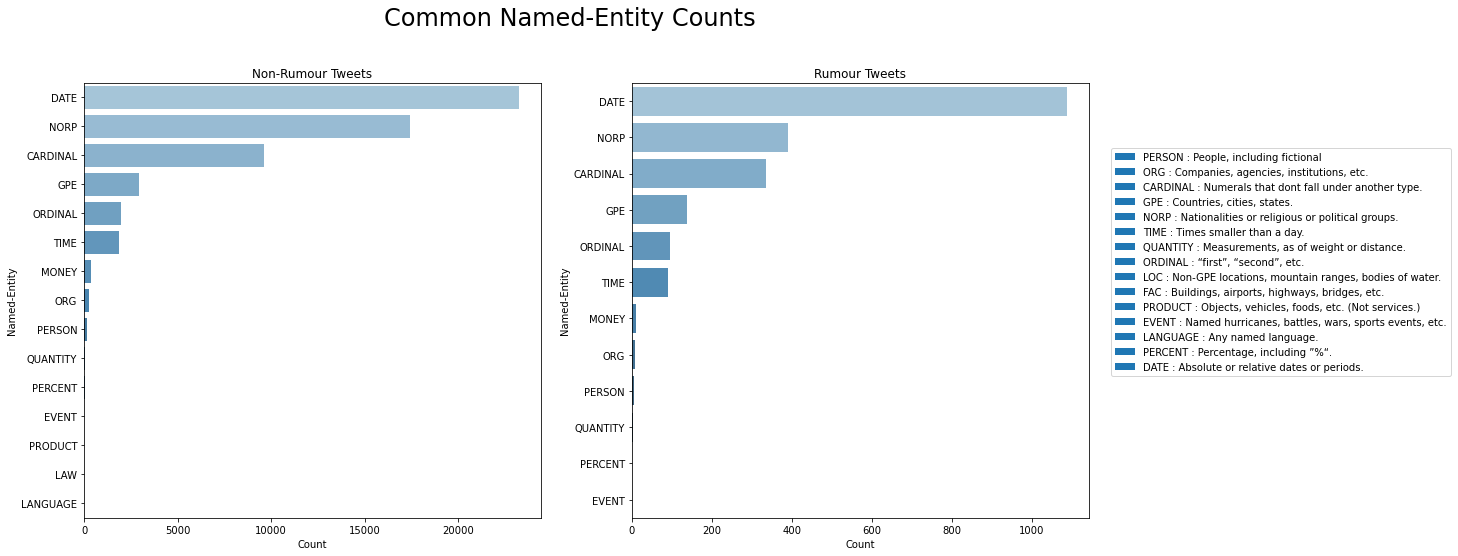

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='Blues_d')

axes[0].set_title('Non-Rumour Tweets')
axes[1].set_title('Rumour Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

## Analysis 2:  What are the popular hashtags of COVID-19 rumours and non-rumours? How much overlap or difference do they share?

In [26]:
hashtags = [
    covid_df[covid_df['label'] == 0]['hashtags'],
    covid_df[covid_df['label'] == 1]['hashtags']
]

In [27]:
hashtags[0][3]

[]

/Users/bachfischer/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/bachfischer/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


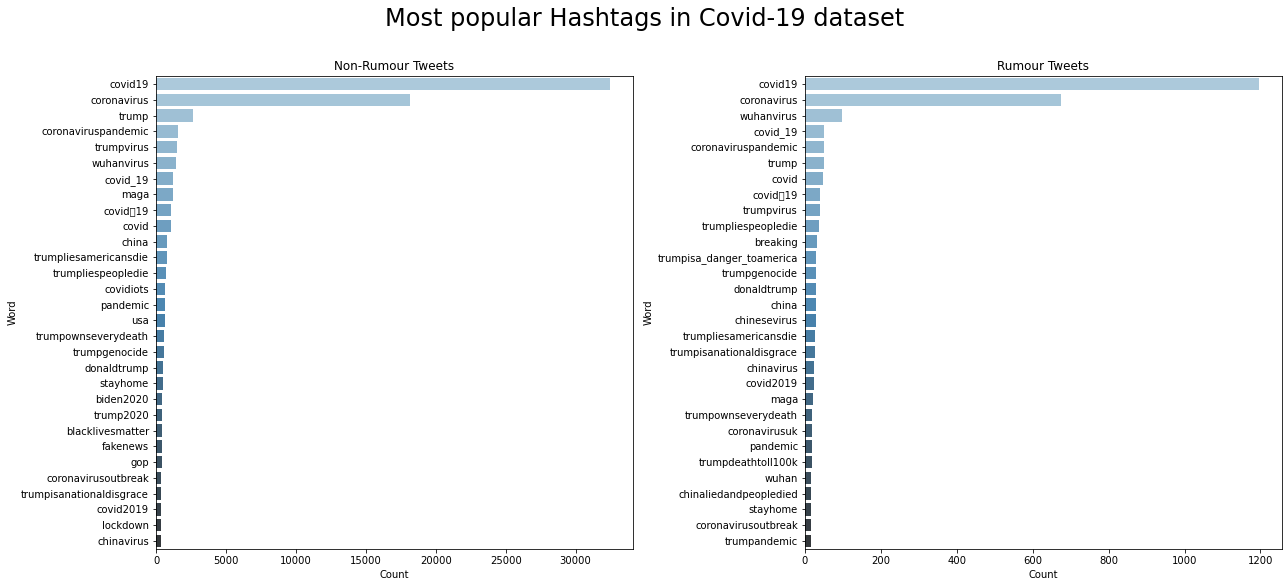

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(hashtags, axes):

    new = i.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stopword) and (word != '...'):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='Blues_d', ax=j)
    
axes[0].set_title('Non-Rumour Tweets')
axes[1].set_title('Rumour Tweets')

axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most popular Hashtags in Covid-19 dataset', fontsize=24, va='baseline')
plt.tight_layout()

In [29]:
counter = {}
for i, j in zip(hashtags, ['non_rumour' ,'rumour']):

    new = i.values.tolist()
    corpus = [word for i in new for word in i]

    counter[j] = Counter(corpus)

In [30]:
non_rumour = []
rumour = []

for key, value in counter['non_rumour'].most_common(n = 30):
    non_rumour.append(key)

for key, value in counter['rumour'].most_common(n = 30):
    rumour.append(key)

The following hashtags are present in the most-common hashtags of both tweet chains

In [31]:
intersection = set(non_rumour).intersection(set(rumour))

In [32]:
intersection

{'china',
 'chinavirus',
 'coronavirus',
 'coronavirusoutbreak',
 'coronaviruspandemic',
 'covid',
 'covid19',
 'covid2019',
 'covid_19',
 'covidー19',
 'donaldtrump',
 'maga',
 'pandemic',
 'stayhome',
 'trump',
 'trumpgenocide',
 'trumpisanationaldisgrace',
 'trumpliesamericansdie',
 'trumpliespeopledie',
 'trumpownseverydeath',
 'trumpvirus',
 'wuhanvirus'}

The following hashtags are only present in one tweet chain (i.e. either in non-rumours or rumours)

In [33]:
difference = list(set(non_rumour) ^ set(rumour))

In [34]:
difference

['blacklivesmatter',
 'breaking',
 'trumpisa_danger_toamerica',
 'gop',
 'wuhan',
 'fakenews',
 'chinesevirus',
 'lockdown',
 'coronavirusuk',
 'trumpdeathtoll100k',
 'biden2020',
 'chinaliedandpeopledied',
 'usa',
 'covidiots',
 'trump2020',
 'trumpandemic']

In [35]:
set(counter['non_rumour'].most_common(n = 30))

{('biden2020', 454),
 ('blacklivesmatter', 428),
 ('china', 776),
 ('chinavirus', 336),
 ('coronavirus', 18176),
 ('coronavirusoutbreak', 379),
 ('coronaviruspandemic', 1577),
 ('covid', 1058),
 ('covid19', 32456),
 ('covid2019', 360),
 ('covid_19', 1208),
 ('covidiots', 643),
 ('covidー19', 1068),
 ('donaldtrump', 517),
 ('fakenews', 422),
 ('gop', 414),
 ('lockdown', 357),
 ('maga', 1197),
 ('pandemic', 623),
 ('stayhome', 482),
 ('trump', 2619),
 ('trump2020', 444),
 ('trumpgenocide', 560),
 ('trumpisanationaldisgrace', 370),
 ('trumpliesamericansdie', 747),
 ('trumpliespeopledie', 679),
 ('trumpownseverydeath', 569),
 ('trumpvirus', 1479),
 ('usa', 617),
 ('wuhanvirus', 1422)}

## Analysis 3: Do rumour source tweets convey a different sentiment/emotion to the non-rumour source tweets? What about their replies?

In [36]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bachfischer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [37]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [38]:
print(covid_df['source_tweet'][0])
sia.polarity_scores(covid_df['source_tweet'][0])

according to the new york times  warner bros  wanted to delay christopher nolan s tenet months ago due to the covid    pandemic but nolan refused to listen to any discussions  the studio kept the original release date to  keep [nolan] happy


{'neg': 0.092, 'neu': 0.743, 'pos': 0.165, 'compound': 0.6757}

### Check sentiment of source tweets

In [39]:
source_tweets = [
    covid_df[covid_df['label'] == 0]['source_tweet'],
    covid_df[covid_df['label'] == 1]['source_tweet']
]

In [40]:
def get_relative_scores_for_tweets(tweet_corpus):
    scores = {}
    scores['neg'] = 0
    scores['neu'] = 0
    scores['pos'] = 0
    scores['compound'] = 0

    for source_tweet in tweet_corpus:
        score = sia.polarity_scores(str(source_tweet))
        scores['neg'] += score['neg']
        scores['neu'] += score['neu']
        scores['pos'] += score['pos']
        scores['compound'] += score['compound']
    
    number_of_tweets = len(tweet_corpus)
    scores['neg'] = scores['neg']/number_of_tweets
    scores['neu'] = scores['neu']/number_of_tweets
    scores['pos'] = scores['pos']/number_of_tweets
    scores['compound'] = scores['compound']/number_of_tweets



    
    return scores

In [41]:
non_rumour_sentiment_scores_source = get_relative_scores_for_tweets(source_tweets[0])
rumour_sentiment_scores_source = get_relative_scores_for_tweets(source_tweets[1])

In [42]:
print('Sentiment of non-rumour tweets:')
print(non_rumour_sentiment_scores_source)
print('Sentiment of rumour tweets:')
print(rumour_sentiment_scores_source)

Sentiment of non-rumour tweets:
{'neg': 0.09399859499083638, 'neu': 0.813667012828345, 'pos': 0.0871383017715332, 'compound': -0.024559529627367255}
Sentiment of rumour tweets:
{'neg': 0.09495863970588235, 'neu': 0.8326323529411769, 'pos': 0.06503216911764698, 'compound': -0.09371332720588244}


### Check sentiment of reply tweets

In [43]:
replies = [
    covid_df[covid_df['label'] == 0]['replies'],
    covid_df[covid_df['label'] == 1]['replies']
]

In [44]:
replies[0][3][0]

'let is not play blind that the work is fighting islamic religion through covid'

In [45]:
def get_scores_for_replies(tweet_chains):
    scores_for_all_replies = {}
    scores_for_all_replies['neg'] = 0
    scores_for_all_replies['neu'] = 0
    scores_for_all_replies['pos'] = 0
    scores_for_all_replies['compound'] = 0
    
    for tweet_chain in tweet_chains:
        scores_for_current_replies = get_relative_scores_for_tweets(tweet_chain)
        scores_for_all_replies['neg'] += scores_for_current_replies['neg']
        scores_for_all_replies['neu'] += scores_for_current_replies['neu']
        scores_for_all_replies['pos'] += scores_for_current_replies['pos']
        scores_for_all_replies['compound'] += scores_for_current_replies['compound']
    
    number_of_tweets = len(tweet_chains)
    scores_for_all_replies['neg'] = scores_for_all_replies['neg']/number_of_tweets
    scores_for_all_replies['neu'] = scores_for_all_replies['neu']/number_of_tweets
    scores_for_all_replies['pos'] = scores_for_all_replies['pos']/number_of_tweets
    scores_for_all_replies['compound'] = scores_for_all_replies['compound']/number_of_tweets

In [46]:
non_rumour_sentiment_scores_replies = get_relative_scores_for_tweets(replies[0])
rumour_sentiment_scores_replies = get_relative_scores_for_tweets(replies[1])

In [47]:
print('Sentiment of replies for non-rumour tweets:')
print(non_rumour_sentiment_scores_replies)
print('Sentiment of rumour tweets:')
print(rumour_sentiment_scores_replies)

Sentiment of replies for non-rumour tweets:
{'neg': 0.09499120342089214, 'neu': 0.8316654856444716, 'pos': 0.07334178375076375, 'compound': -0.23057032987171508}
Sentiment of rumour tweets:
{'neg': 0.07453033088235296, 'neu': 0.8705101102941173, 'pos': 0.05495404411764707, 'compound': -0.15202913602941173}


## Analysis 4: What are the characteristics of rumour-creating users, and how do they differ compared to normal users?

In [48]:
sum(covid_df['retweet_count'])

63561557

Text(0.5, 0, 'Data')

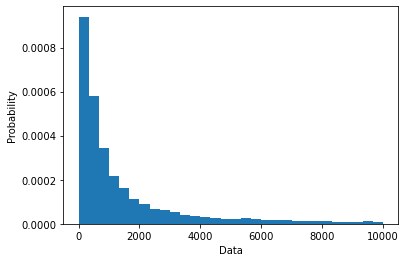

In [49]:
plt.hist(covid_df['retweet_count'], density=True, bins=30, range=(0, 10000))  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [50]:
def plot_characteristics_in_histogram(non_rumour_count, rumour_count, title):
    
    """A function for plotting numerical counts as a Histogram"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(non_rumour_count, ax=axes[0], color='#e74c3c')
    sns.distplot(rumour_count, ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel(title)
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non-Rumour Tweets')
    axes[1].set_xlabel(title)
    axes[1].set_title('Rumour Tweets')
    
    fig.suptitle(title, fontsize=24, va='baseline')
    
    fig.tight_layout()

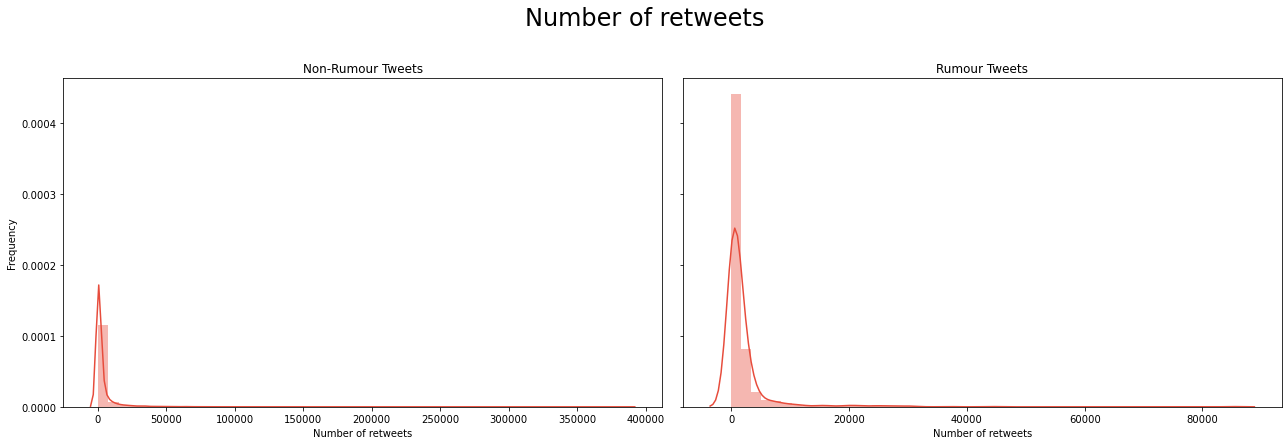

In [51]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['retweet_count'],
                           covid_df[covid_df['label'] == 1]['retweet_count'], 
                                 title = "Number of retweets")

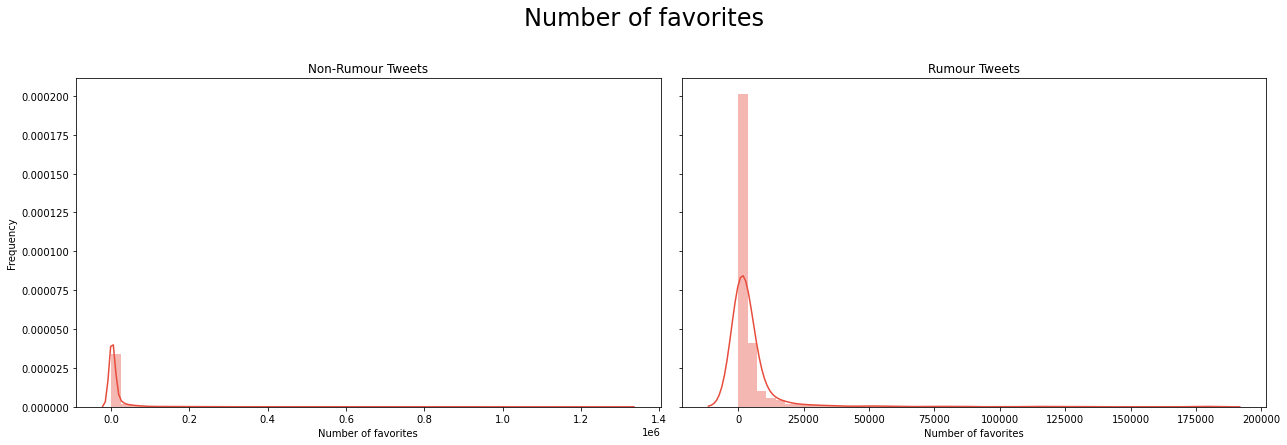

In [52]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['favorite_count'],
                           covid_df[covid_df['label'] == 1]['favorite_count'], 
                                 title = "Number of favorites")

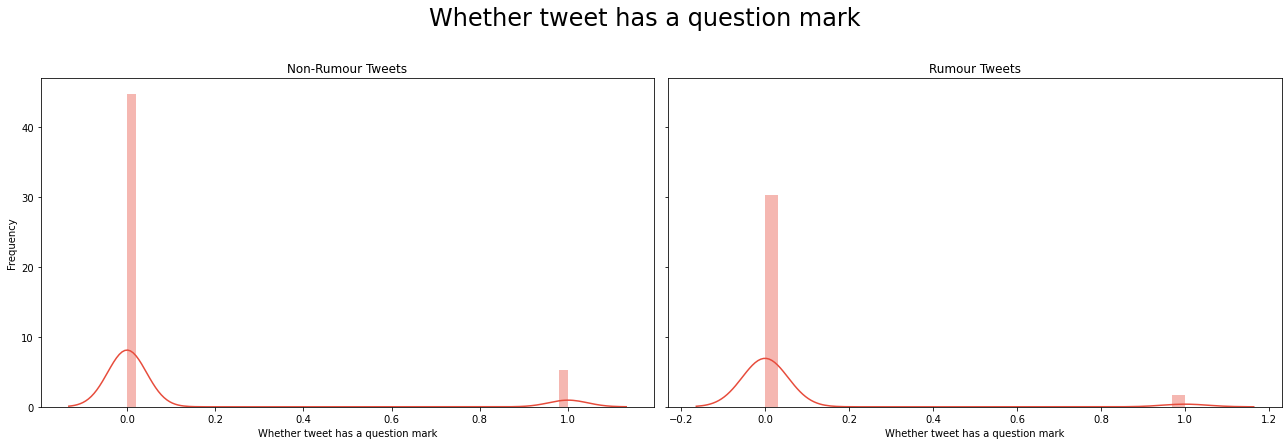

In [53]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['question_mark'],
                           covid_df[covid_df['label'] == 1]['question_mark'], 
                                 title = "Whether tweet has a question mark")

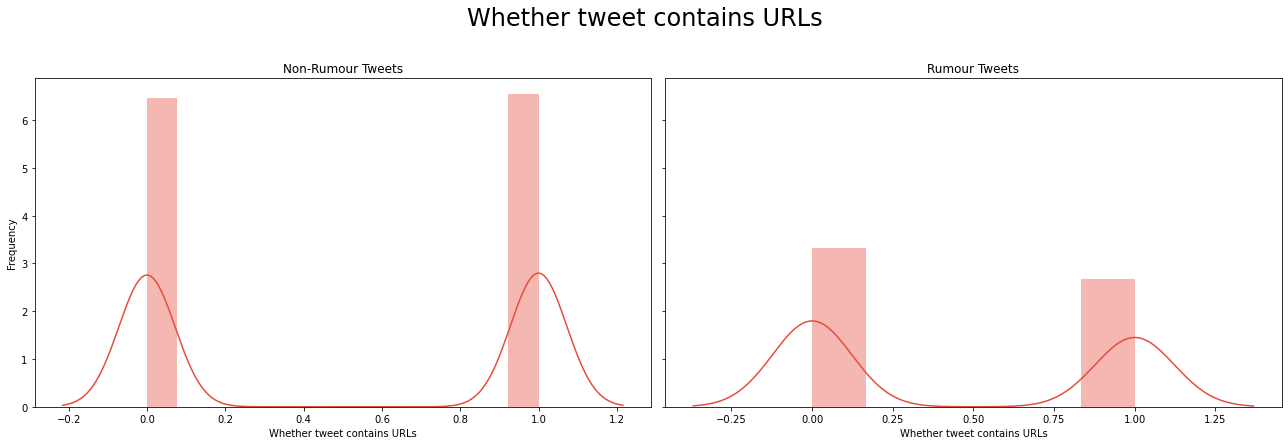

In [54]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['contains_url'],
                           covid_df[covid_df['label'] == 1]['contains_url'], 
                                 title = "Whether tweet contains URLs")

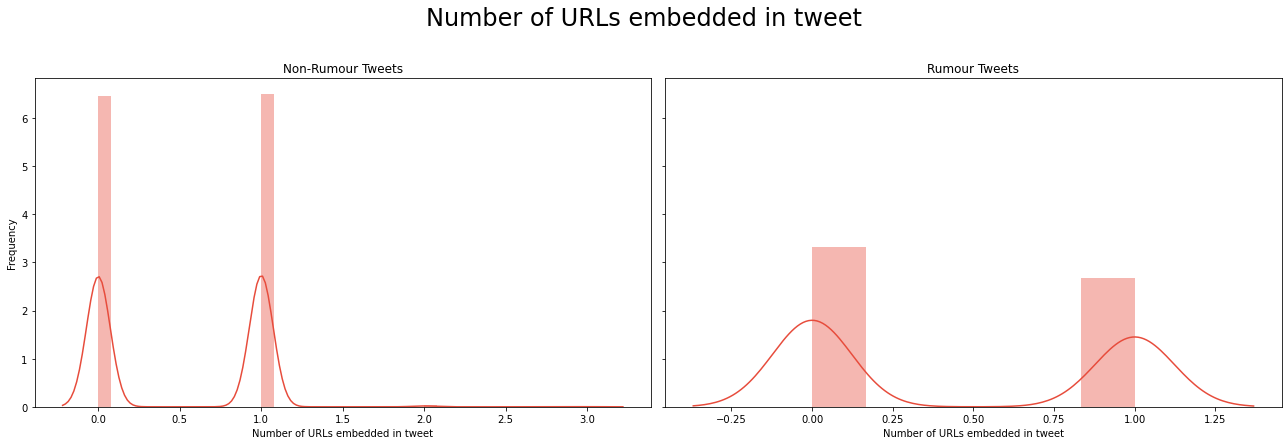

In [55]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['number_urls'],
                           covid_df[covid_df['label'] == 1]['number_urls'], 
                                 title = "Number of URLs embedded in tweet")

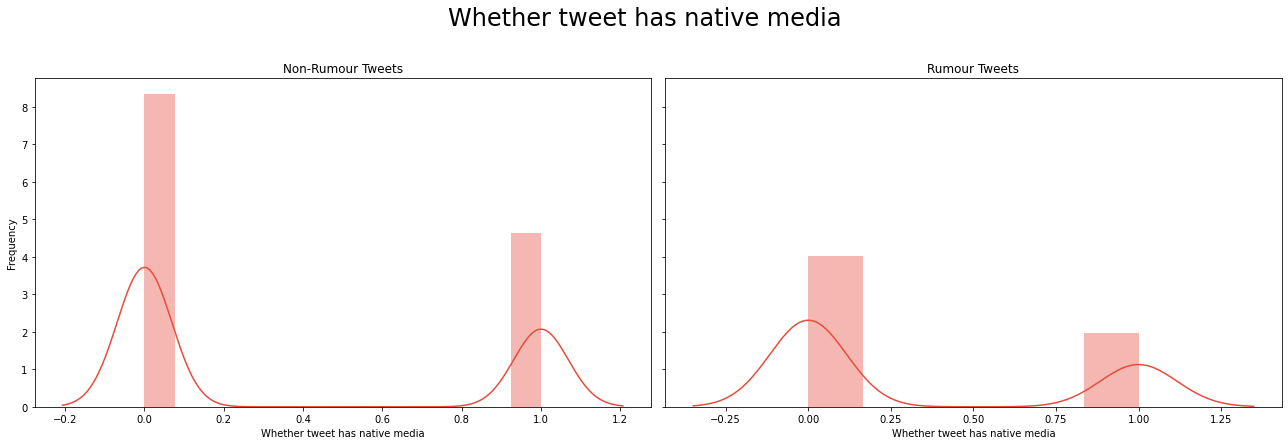

In [56]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['contains_media'],
                           covid_df[covid_df['label'] == 1]['contains_media'], 
                                 title = "Whether tweet has native media")

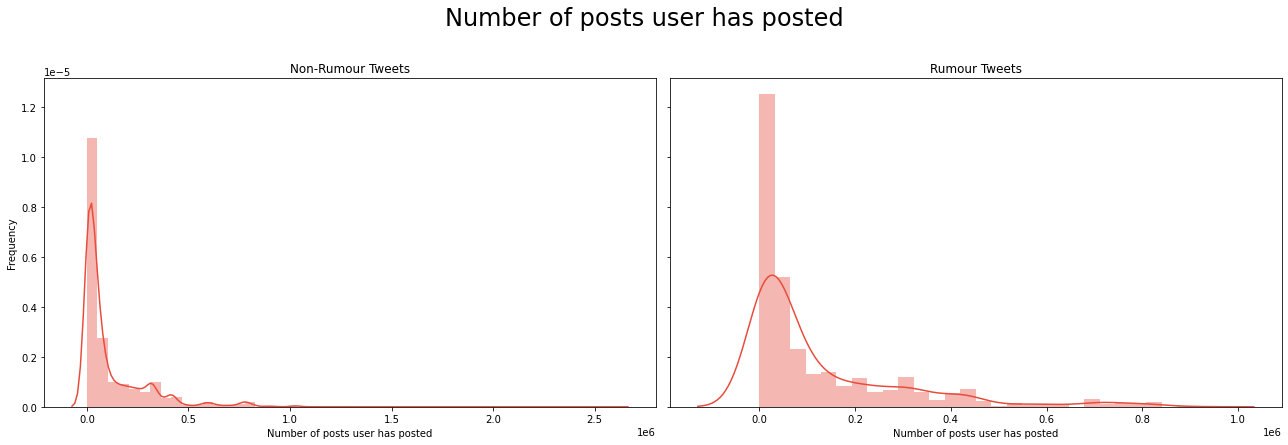

In [57]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['statuses_count'],
                           covid_df[covid_df['label'] == 1]['statuses_count'], 
                                 title = "Number of posts user has posted")

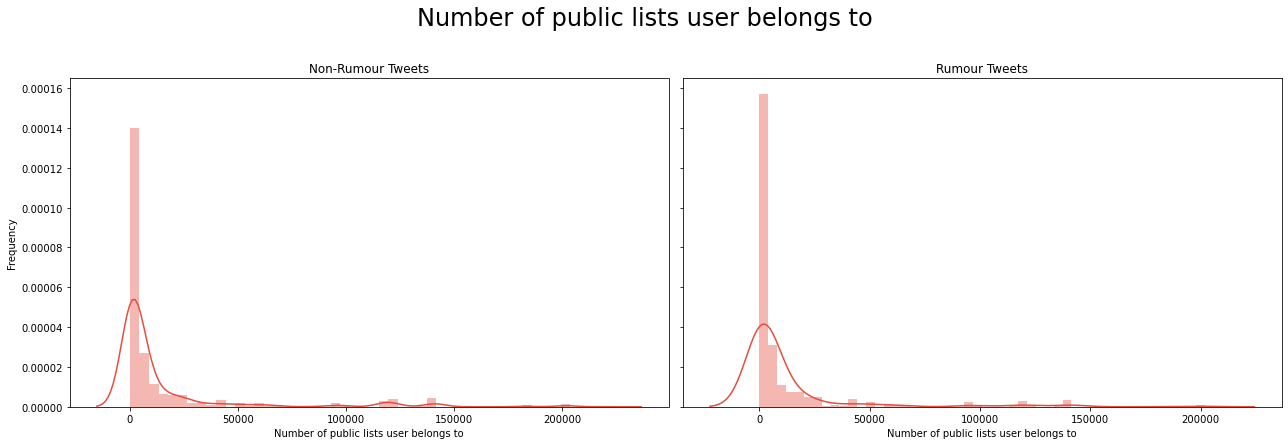

In [58]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['listed_count'],
                           covid_df[covid_df['label'] == 1]['listed_count'], 
                                 title = "Number of public lists user belongs to")

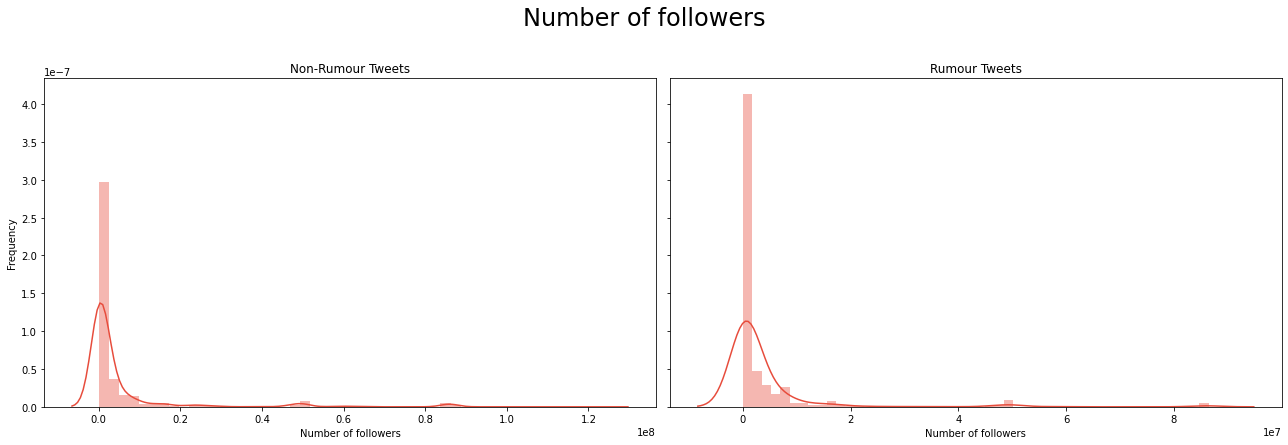

In [59]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['followers_count'],
                           covid_df[covid_df['label'] == 1]['followers_count'], 
                                 title = "Number of followers")

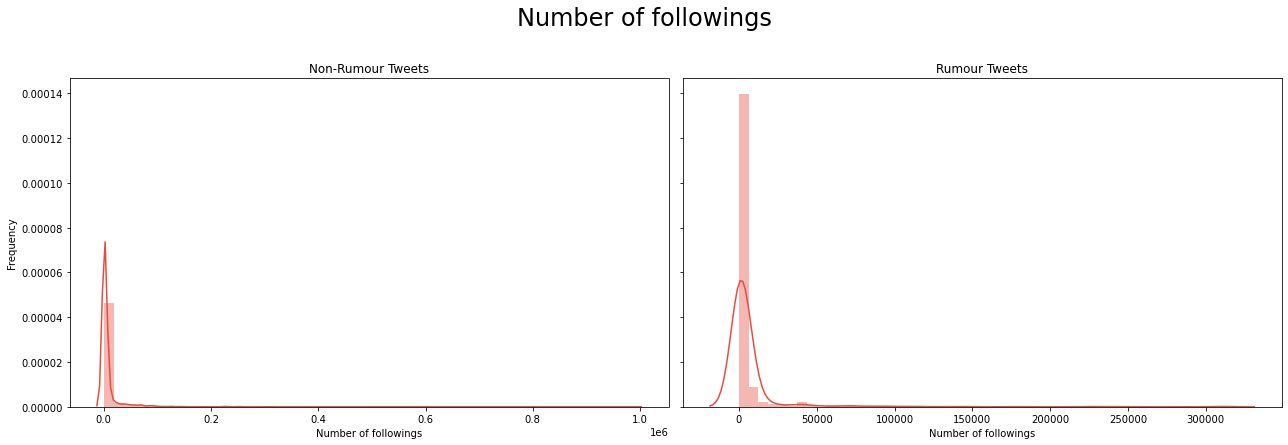

In [60]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['friends_count'],
                           covid_df[covid_df['label'] == 1]['friends_count'], 
                                 title = "Number of followings")

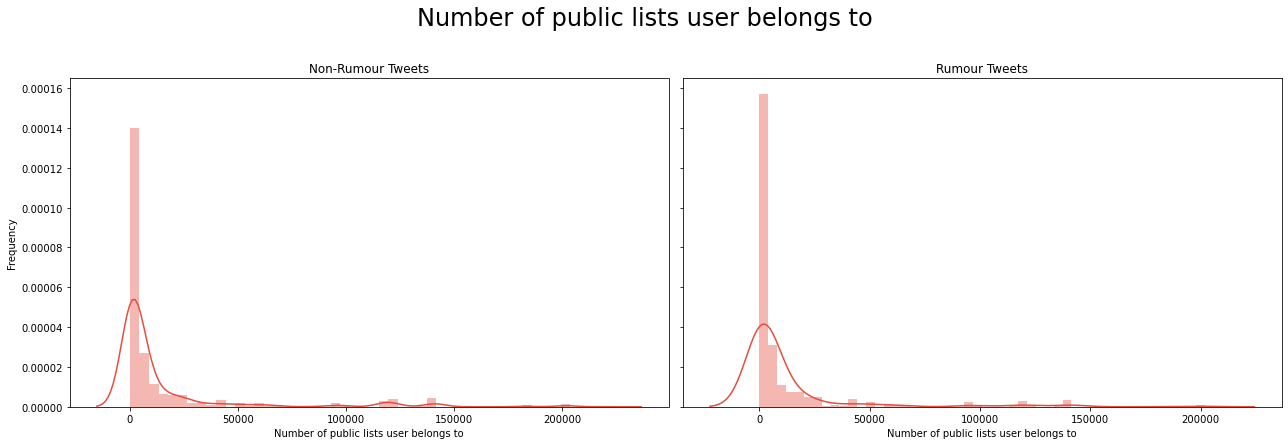

In [61]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['listed_count'],
                           covid_df[covid_df['label'] == 1]['listed_count'], 
                                 title = "Number of public lists user belongs to")

/Users/bachfischer/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/bachfischer/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


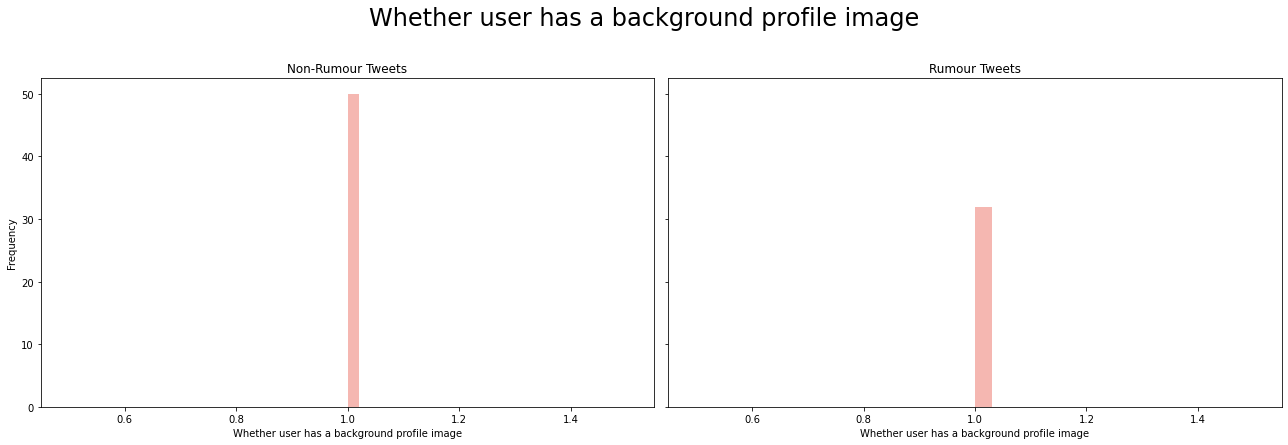

In [62]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['contains_profile_background_image'],
                           covid_df[covid_df['label'] == 1]['contains_profile_background_image'], 
                                 title = "Whether user has a background profile image")

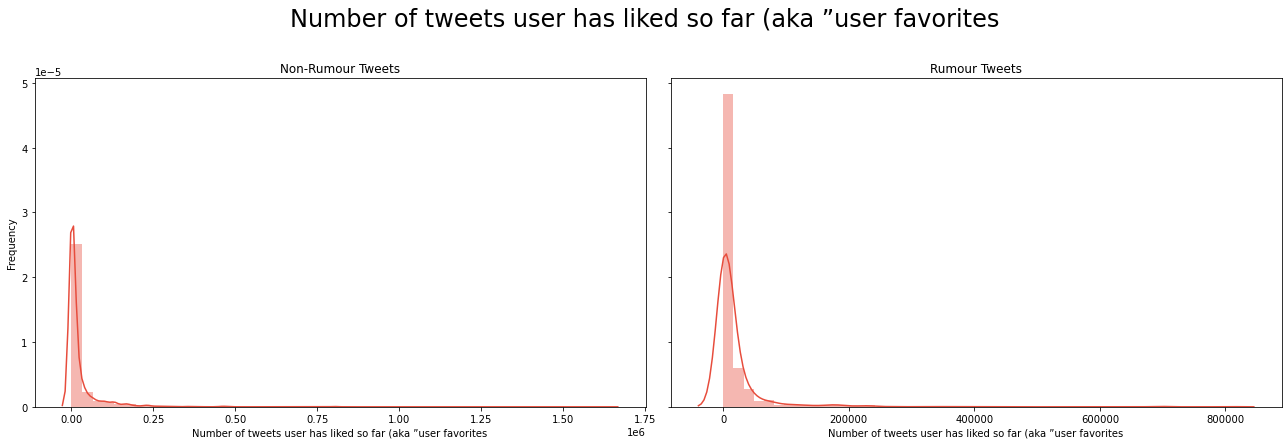

In [63]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['favourites_count'],
                           covid_df[covid_df['label'] == 1]['favourites_count'], 
                                 title = "Number of tweets user has liked so far (aka ”user favorites")

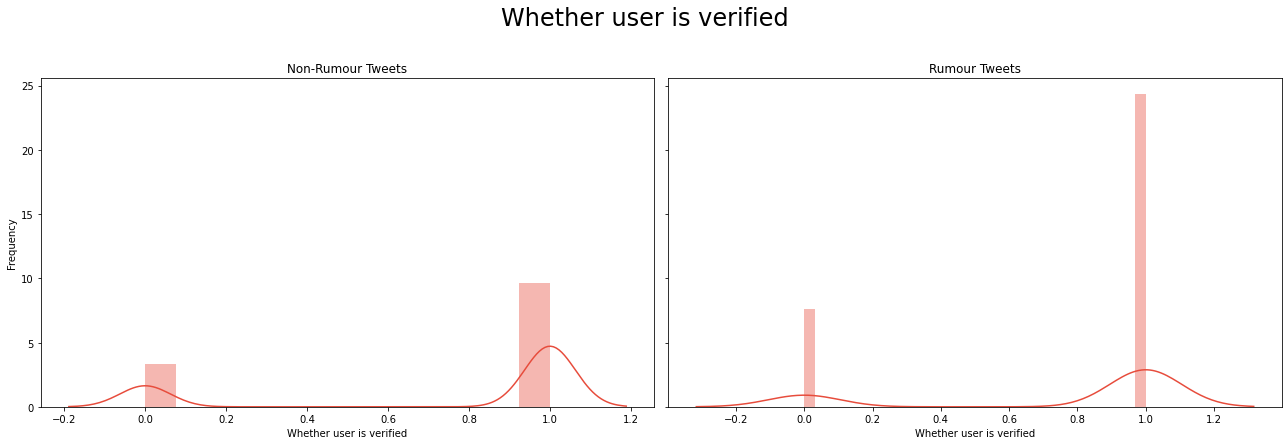

In [64]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['verified'],
                           covid_df[covid_df['label'] == 1]['verified'], 
                                 title = "Whether user is verified")

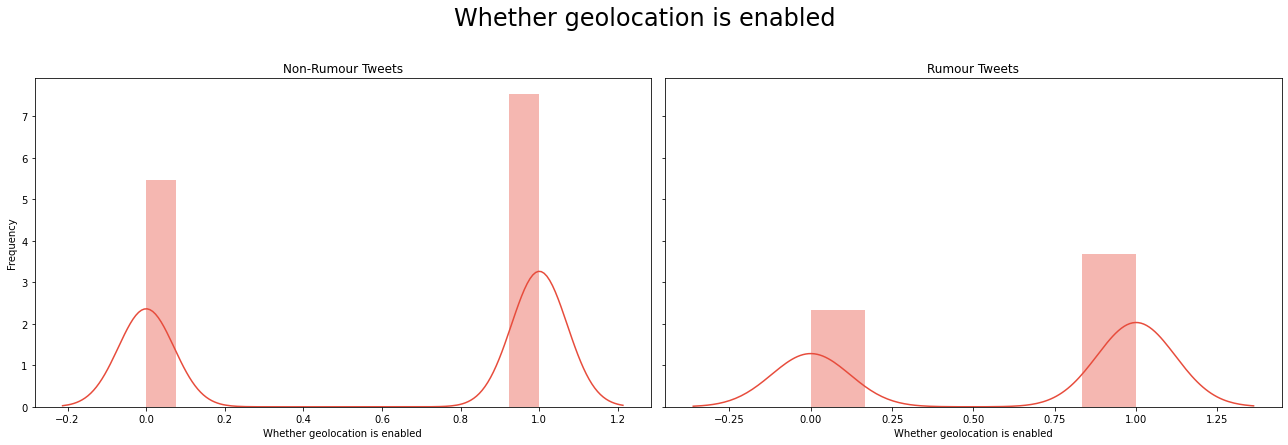

In [65]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['geo_enabled'],
                           covid_df[covid_df['label'] == 1]['geo_enabled'], 
                                 title = "Whether geolocation is enabled")

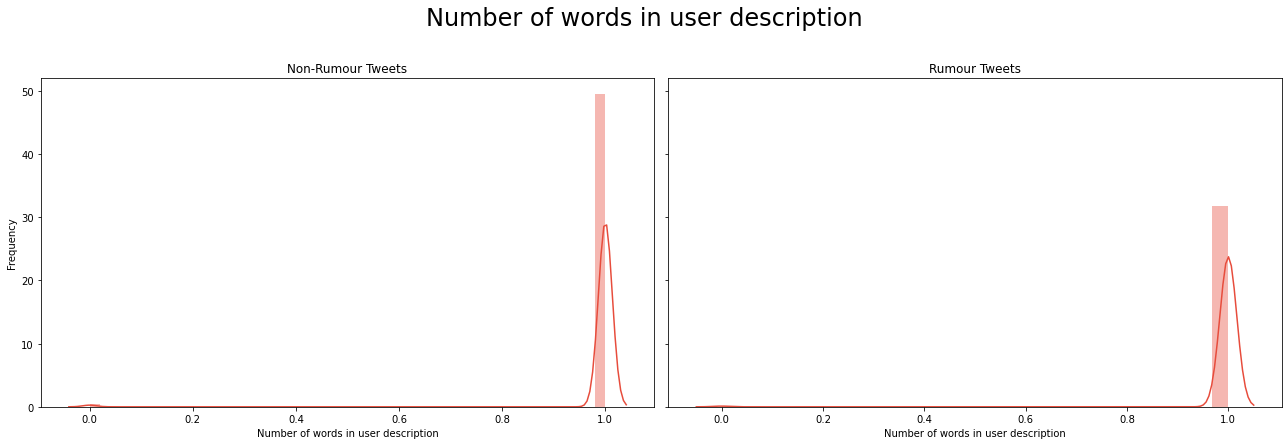

In [66]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['has_description'],
                           covid_df[covid_df['label'] == 1]['has_description'], 
                                 title = "Number of words in user description")

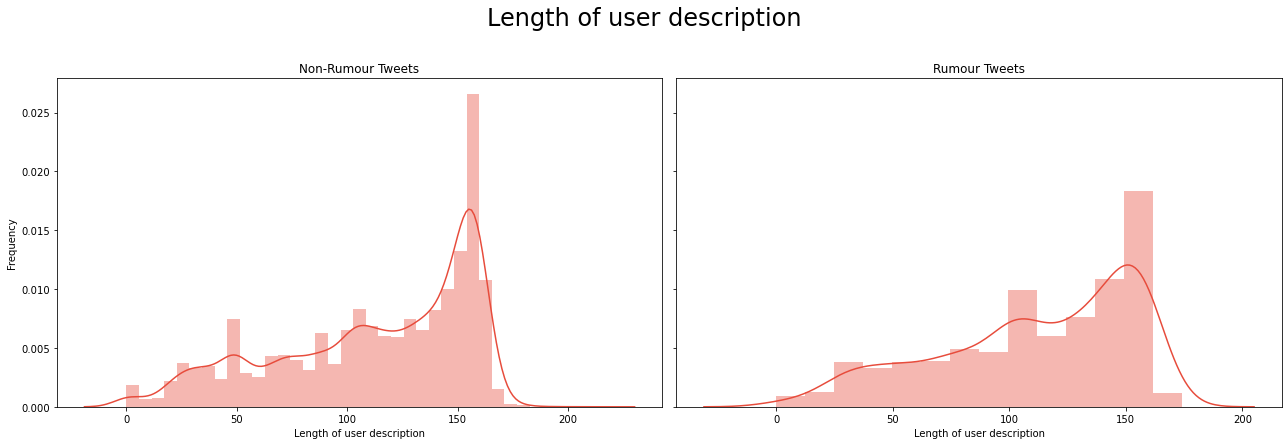

In [67]:
plot_characteristics_in_histogram(covid_df[covid_df['label'] == 0]['length_description'],
                           covid_df[covid_df['label'] == 1]['length_description'], 
                                 title = "Length of user description")